# Spectrum Generation

We use the data to generate spectra for the incidence of particles on the detector

In [2]:
#Include modules
from accelerate import *
from tqdm.notebook import tqdm

%matplotlib widget

In [3]:
# Read the files

# Parameters
run                     = 'run0'

# Find the files
foldername  = f'./data/{run}'
filenames   = [os.path.join(foldername,filename) for filename in os.listdir(foldername)]

# Print the number of files found
print(f'Found {len(filenames)} data files in {foldername}')

Found 11 data files in ./data/run0


Cm244:   0%|          | 0/5 [00:00<?, ?it/s]

loadFile:   0%|          | 0/11 [00:00<?, ?it/s]

getEnergy:   0%|          | 0/11 [00:00<?, ?it/s]

smearEnergy:   0%|          | 0/11 [00:00<?, ?it/s]

loadFile: 0it [00:00, ?it/s]

getEnergy: 0it [00:00, ?it/s]

smearEnergy: 0it [00:00, ?it/s]

ValueError: No objects to concatenate

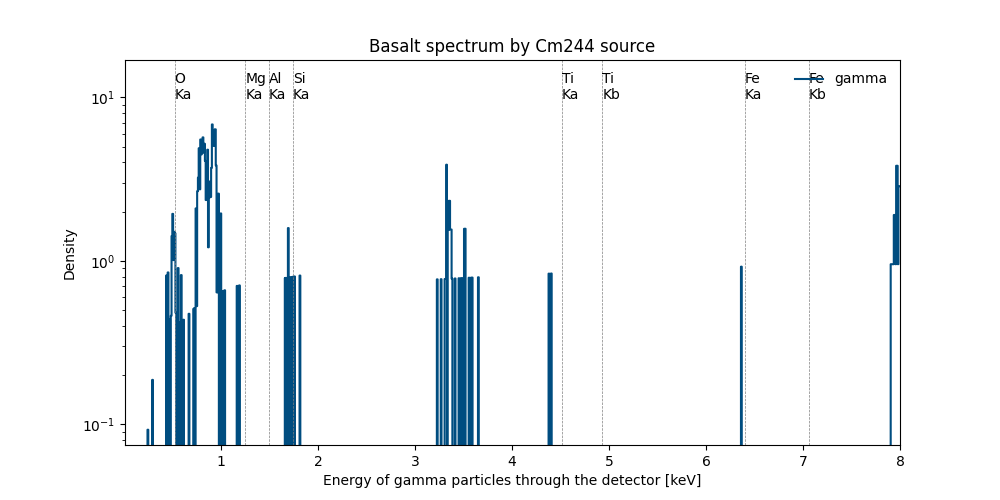

In [ ]:
RUN_STRUCTURE = {
    'nt' : 'Cm244',
    # 'run1' : 'Fe55',
    # 'run2' : 'Cd109',
    # 'run3' : 'Co60',
    # 'run4' : 'Am241'
}

MATERIAL = {
    'name' : 'Basalt',
    'peaks' : {
        'Fe\nKa' : 6.40,
        'Fe\nKb' : 7.06,
        'Ti\nKa' : 4.51,
        'Ti\nKb' : 4.93,
        'Si\nKa' : 1.74,
        'Al\nKa' : 1.49,
        'Mg\nKa' : 1.25,
        'O\nKa'  : 0.52,
    }
}

STD                 = 0.04
particleEnergyList  = {}
PARTICLES           = ['gamma']
EFFICIENCY          = pd.read_csv('./data/SDD_Efficiency/C1.csv', names=['Energy','Efficiency'])

# For all the simulation runs
pbar = tqdm(RUN_STRUCTURE,desc=list(RUN_STRUCTURE.values())[0])
for i,run in enumerate(pbar):
    # Collect their output files
    files = loadFiles([filename for filename in filenames if run in filename])
    print(files)
    

    # Extract the energy for each particle
    particleEnergyList[run] = getParticleEnergiesSmeared(files,
        smearfunc   = smear_gaussian,
        size        = STD,
        groupBy     = 'TrackID',
        columnName  = 'InitialEnergy'
        )
    
    particles = None
    try:
        particles = pd.concat([particleEnergyList[run][p] for p in PARTICLES])
    except:
        pass
    
    # Plot the spectrum
    if particles is not None : plotParticleHistogram(particles,
        source          = RUN_STRUCTURE[run],
        PARTICLE        = ' and '.join(PARTICLES),
        MATERIAL        = MATERIAL,
        SHOW_MATERIAL   = True,
        LIMS            = (0,8),
        MAX_PEAKS       = 0,
        NBINS           = 1000,
        SAVE            = True,
        yscale          = 'log',
        efficiency      = EFFICIENCY)

    # Change the description of the progress bar to show the material processed
    try:
        pbar.set_description(list(RUN_STRUCTURE.values())[i+1])
    except:
        pass

In [4]:
print("The unique particles are:")
for run in particleEnergyList:
    print(f'{run}:',[[particle, len(particleEnergyList[run][particle])] for particle in particleEnergyList[run]])

The unique particles are:
run0: [['e-', 189680], ['gamma', 119106], ['neutron', 38], ['alpha', 20]]
run1: [['e-', 15510302], ['gamma', 1306783], ['neutron', 38], ['alpha', 25]]
run2: [['e-', 7711102], ['gamma', 1075662]]
run3: [['e-', 2568473], ['gamma', 43364]]
run4: [['gamma', 54060], ['e-', 87983], ['alpha', 5]]
